In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from nuclear_matter.stats_utils import *
from nuclear_matter.matter import *
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
import seaborn as sns
import time
from itertools import product
from tqdm import tqdm

%matplotlib inline

In [2]:
# # Lambda = 450
# Lambda = 500

# high_density = True
# # if high_density:
# #     filename = '../data/all_matter_data_high_density.csv'
# # else:
# #     filename = '../data/all_matter_data.csv'
    
# # data = InputData(filename, Lambda, high_density)

# filename_low = filename = '../data/all_matter_data.csv'
# filename_high = filename = '../data/all_matter_data_high_density.csv'
    
# data_high_density = InputData(filename_high, Lambda, high_density)
# data_low_density = InputData(filename_low, Lambda, False)

# if high_density:
#     data = data_high_density
# else:
#     data = data_low_density

In [3]:
high_density = True
# if high_density:
#     filename = '../data/all_matter_data_high_density.csv'
# else:
#     filename = '../data/all_matter_data.csv'

# data = InputData(filename, Lambda, high_density)

filename_low = '../data/all_matter_data.csv'
filename_high = '../data/all_matter_data_high_density.csv'

df = pd.read_csv(filename_high)
df_smooth = df.copy()

for Lambda in [450, 500]:
    
    data_high_density = InputData(filename_high, Lambda)
    data_low_density = InputData(filename_low, Lambda)

    if high_density:
        data = data_high_density
    else:
        data = data_low_density
    
    kf_n = data.kf_n
    Kf_n = data.Kf_n
    kf_s = data.kf_s
    Kf_s = data.Kf_s
    kf_d = data.kf_avg
    Kf_d = data.Kf_avg

    density = data.density

    ref_2bf = data.ref_2bf
    ref_n_3bf = data.ref_n_3bf
    ref_s_3bf = data.ref_s_3bf
    ref_d_3bf = data.ref_avg_3bf

    y_s_2_plus_3bf = data.y_s_2_plus_3bf
    y_n_2_plus_3bf = data.y_n_2_plus_3bf
    #     y_d_2_plus_3bf = data.y_d_2_plus_3bf

    y_s_2bf = data.y_s_2bf
    y_n_2bf = data.y_n_2bf
    #     y_d_2bf = data.y_d_2bf

    y_s_3bf = data.y_s_3bf
    y_n_3bf = data.y_n_3bf
    #     y_d_3bf = data.y_d_3bf

    fit_n2lo = data.fit_n2lo
    fit_n3lo = data.fit_n3lo


    min_uncertainty = 0.02  # Twenty keV

    err_y_n = np.abs(y_n_2_plus_3bf[:, -1]) * 0.005
    err_y_n[np.abs(err_y_n) < min_uncertainty] = min_uncertainty

    err_y_s = np.abs(y_s_2_plus_3bf[:, -1]) * 0.005
    err_y_s[np.abs(err_y_s) < min_uncertainty] = min_uncertainty

#     err_y_d = np.abs(y_d_2_plus_3bf[:, -1]) * 0.005
#     err_y_d[np.abs(err_y_d) < min_uncertainty] = min_uncertainty

    kernel = ConstantKernel() * RBF(length_scale_bounds=(0.1, 10))
    gp_s = GaussianProcessRegressor(kernel, alpha=err_y_s**2)
    gp_n = GaussianProcessRegressor(kernel, alpha=err_y_n**2)


    gp_s.fit(Kf_s, y_s_2_plus_3bf)
    y_s_23bf_smooth = gp_s.predict(Kf_s)
    print(gp_s.kernel_)

    gp_s.fit(Kf_s, y_s_2bf)
    y_s_2bf_smooth = gp_s.predict(Kf_s)

    gp_s.fit(Kf_s, y_s_3bf)
    y_s_3bf_smooth = gp_s.predict(Kf_s)
    
    
    gp_n.fit(Kf_n, y_n_2_plus_3bf)
    y_n_23bf_smooth = gp_n.predict(Kf_n)
    print(gp_n.kernel_)

    gp_n.fit(Kf_n, y_n_2bf)
    y_n_2bf_smooth = gp_n.predict(Kf_n)

    gp_n.fit(Kf_n, y_n_3bf)
    y_n_3bf_smooth = gp_n.predict(Kf_n)


    for i, order in enumerate(['LO', 'NLO', 'N2LO', 'N3LO']):
        mask_i = \
            (df_smooth['OrderEFT'] == order) & \
            (df_smooth['Lambda'] == Lambda)
        df_smooth.loc[
            mask_i & (df_smooth['x'] == 0.5) & (df_smooth['Body'] == 'NN-only'),
            'total'
        ] = y_s_2bf_smooth[:, i]
        df_smooth.loc[
            mask_i & (df_smooth['x'] == 0.5) & (df_smooth['Body'] == 'NN+3N'),
            'total'
        ] = y_s_23bf_smooth[:, i]
        
        df_smooth.loc[
            mask_i & (df_smooth['x'] == 0.) & (df_smooth['Body'] == 'NN-only'),
            'total'
        ] = y_n_2bf_smooth[:, i]
        df_smooth.loc[
            mask_i & (df_smooth['x'] == 0.) & (df_smooth['Body'] == 'NN+3N'),
            'total'
        ] = y_n_23bf_smooth[:, i]

34.2**2 * RBF(length_scale=0.521)
38.3**2 * RBF(length_scale=0.894)
144**2 * RBF(length_scale=0.848)
42**2 * RBF(length_scale=0.822)


In [4]:
if high_density:
    df_smooth.to_csv('../data/all_matter_data_high_density_smooth.csv')
else:
    df_smooth.to_csv('../data/all_matter_data_smooth.csv')

In [5]:
df_smooth

,kf,n,Kin,MBPT_HF,MBPT_2,MBPT_3,MBPT_4,total,Lambda,OrderEFT,Body,x,fit
0,1.13972,0.05,16.16071,-5.56660,-1.93533,0.01619,-0.03168,8.634996,450,LO,NN-only,0.0,NaN
1,1.21113,0.06,18.24937,-6.53108,-2.06096,0.10349,-0.04271,9.729832,450,LO,NN-only,0.0,NaN
2,1.27499,0.07,20.22456,-7.47207,-2.14500,0.17957,-0.05451,10.742630,450,LO,NN-only,0.0,NaN
3,1.33302,0.08,22.10753,-8.39215,-2.19485,0.24304,-0.07415,11.694663,450,LO,NN-only,0.0,NaN
4,1.38640,0.09,23.91344,-9.29313,-2.21891,0.29680,-0.09426,12.600270,450,LO,NN-only,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,1.64376,0.30,33.61562,-12.13372,-26.83267,-0.83504,0.68656,-5.508823,500,N3LO,NN+3N,0.5,10.0
956,1.66182,0.31,34.35855,-10.85481,-27.73992,-0.65596,0.69326,-4.212429,500,N3LO,NN+3N,0.5,10.0
957,1.67950,0.32,35.09352,-9.49548,-28.66958,-0.48534,0.70949,-2.838356,500,N3LO,NN+3N,0.5,10.0
958,1.69682,0.33,35.82088,-8.05775,-29.63094,-0.25709,0.73037,-1.389616,500,N3LO,NN+3N,0.5,10.0


In [6]:
df

,kf,n,Kin,MBPT_HF,MBPT_2,MBPT_3,MBPT_4,total,Lambda,OrderEFT,Body,x,fit
0,1.13972,0.05,16.16071,-5.56660,-1.93533,0.01619,-0.03168,8.64329,450,LO,NN-only,0.0,NaN
1,1.21113,0.06,18.24937,-6.53108,-2.06096,0.10349,-0.04271,9.71811,450,LO,NN-only,0.0,NaN
2,1.27499,0.07,20.22456,-7.47207,-2.14500,0.17957,-0.05451,10.73255,450,LO,NN-only,0.0,NaN
3,1.33302,0.08,22.10753,-8.39215,-2.19485,0.24304,-0.07415,11.68942,450,LO,NN-only,0.0,NaN
4,1.38640,0.09,23.91344,-9.29313,-2.21891,0.29680,-0.09426,12.60394,450,LO,NN-only,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,1.64376,0.30,33.61562,-12.13372,-26.83267,-0.83504,0.68656,-5.49925,500,N3LO,NN+3N,0.5,10.0
956,1.66182,0.31,34.35855,-10.85481,-27.73992,-0.65596,0.69326,-4.19888,500,N3LO,NN+3N,0.5,10.0
957,1.67950,0.32,35.09352,-9.49548,-28.66958,-0.48534,0.70949,-2.84739,500,N3LO,NN+3N,0.5,10.0
958,1.69682,0.33,35.82088,-8.05775,-29.63094,-0.25709,0.73037,-1.39453,500,N3LO,NN+3N,0.5,10.0


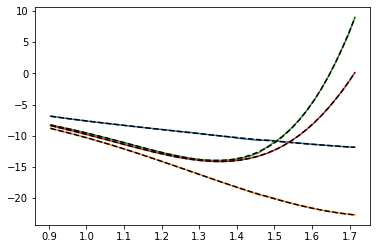

In [7]:
for i in range(4):
    plt.plot(kf_s, y_s_2_plus_3bf[:, i], c=f'C{i}')
    plt.plot(kf_s, y_s_23bf_smooth[:, i], c=r'k', ls='--')

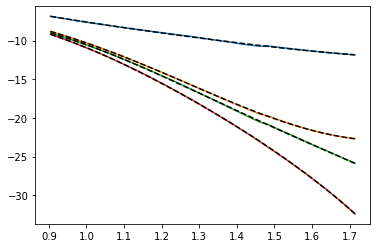

In [8]:
for i in range(4):
    plt.plot(kf_s, y_s_2bf[:, i], c=f'C{i}')
    plt.plot(kf_s, y_s_2bf_smooth[:, i], c=r'k', ls='--')

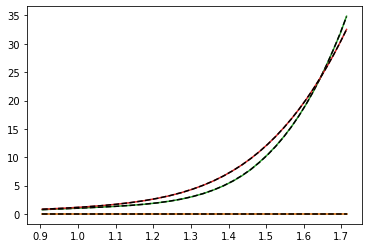

In [9]:
for i in range(4):
    plt.plot(kf_s, y_s_3bf[:, i], c=f'C{i}')
    plt.plot(kf_s, y_s_3bf_smooth[:, i], c=r'k', ls='--')

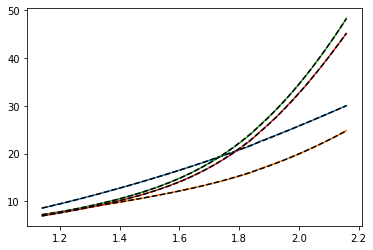

In [10]:
for i in range(4):
    plt.plot(kf_n, y_n_2_plus_3bf[:, i], c=f'C{i}')
    plt.plot(kf_n, y_n_23bf_smooth[:, i], c=r'k', ls='--')

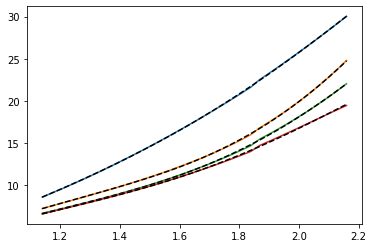

In [11]:
for i in range(4):
    plt.plot(kf_n, y_n_2bf[:, i], c=f'C{i}')
    plt.plot(kf_n, y_n_2bf_smooth[:, i], c=r'k', ls='--')

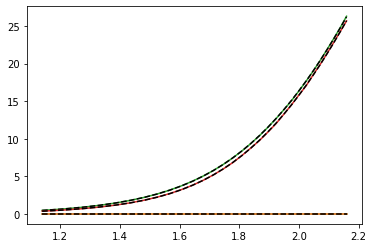

In [12]:
for i in range(4):
    plt.plot(kf_n, y_n_3bf[:, i], c=f'C{i}')
    plt.plot(kf_n, y_n_3bf_smooth[:, i], c=r'k', ls='--')